In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#import dataset
df = pd.read_csv('./dataset/winequality-red.csv')
df.shape

(1599, 12)

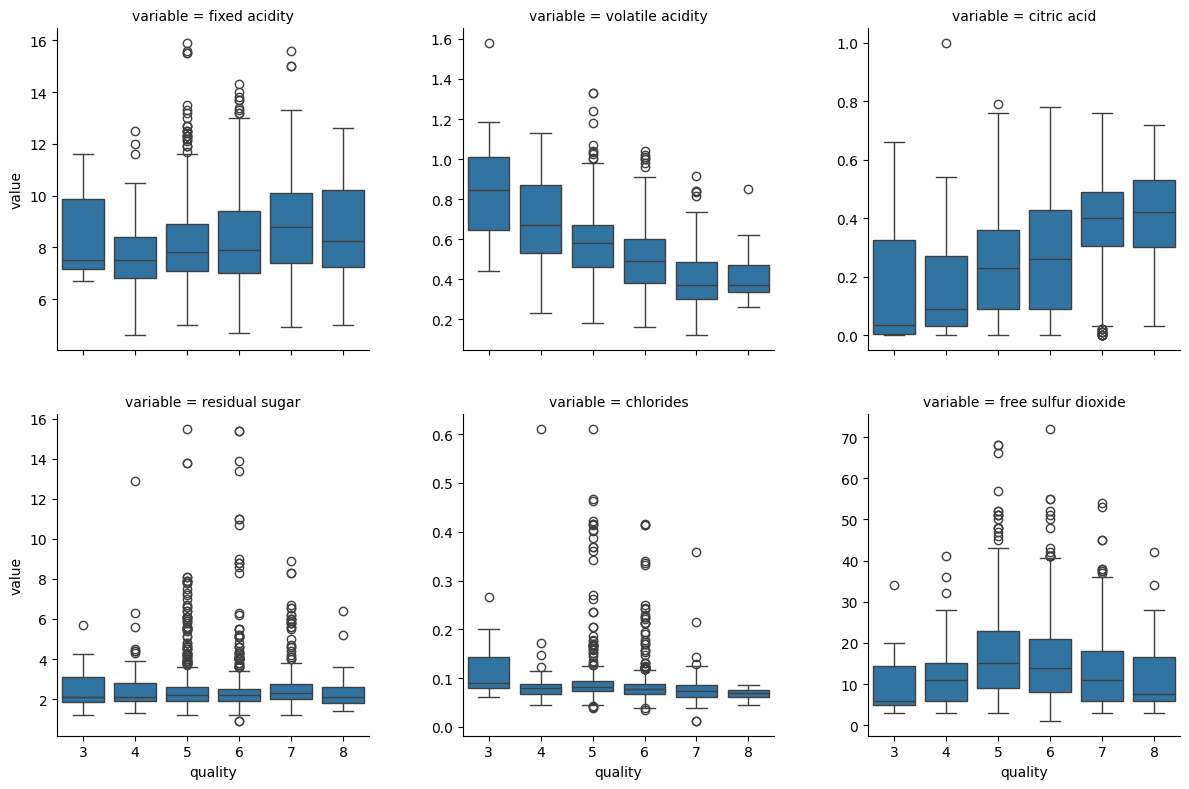

In [4]:
# List of variables to plot
variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide']

# Define the order of 'quality'
order = sorted(df['quality'].unique())

# Use FacetGrid
grid = sns.FacetGrid(data=df.melt(id_vars='quality', value_vars=variables), 
                  col='variable', col_wrap=3, sharey=False, height=4)
grid.map(sns.boxplot, 'quality', 'value', order=order)
grid.figure.subplots_adjust(hspace=0.2, wspace=0.3)

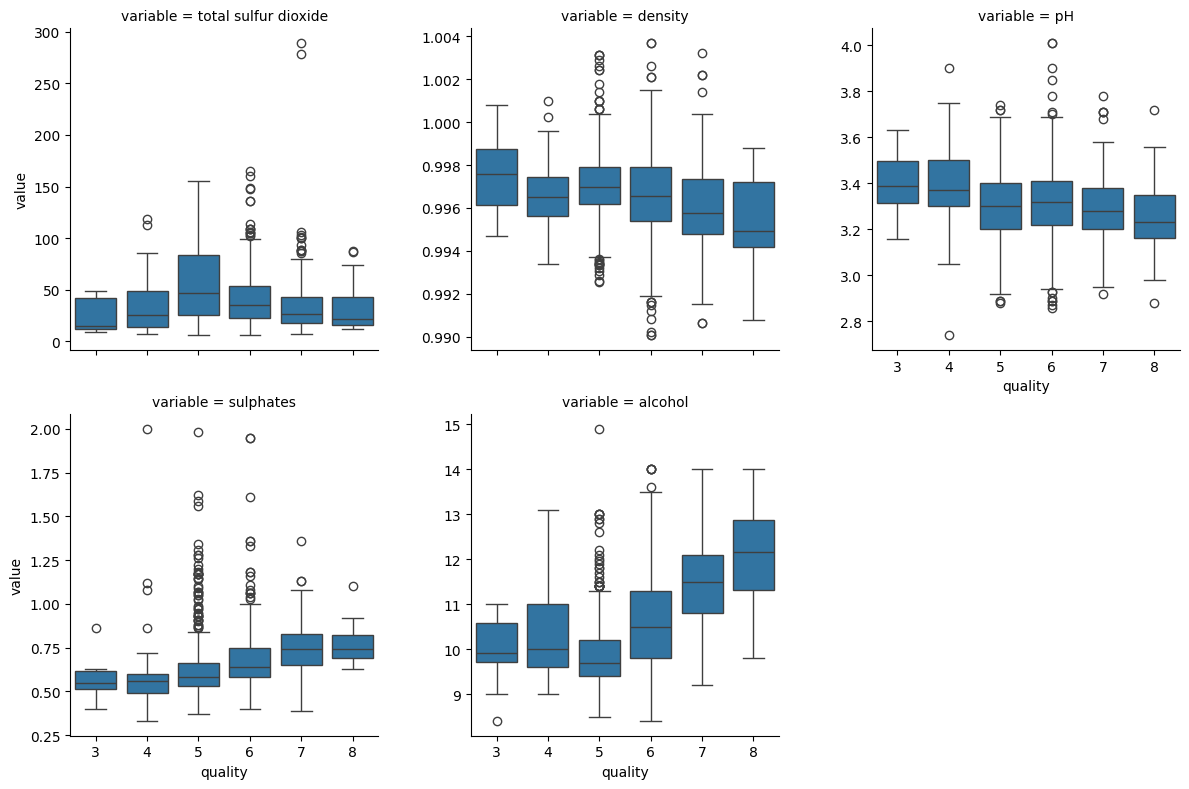

In [5]:
# List of variables to plot
variables = ['total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# Define the order of 'quality'
order = sorted(df['quality'].unique())

# Use FacetGrid
grid = sns.FacetGrid(data=df.melt(id_vars='quality', value_vars=variables), 
                  col='variable', col_wrap=3, sharey=False, height=4)
grid.map(sns.boxplot, 'quality', 'value', order=order)
grid.figure.subplots_adjust(hspace=0.2, wspace=0.3)

<Axes: >

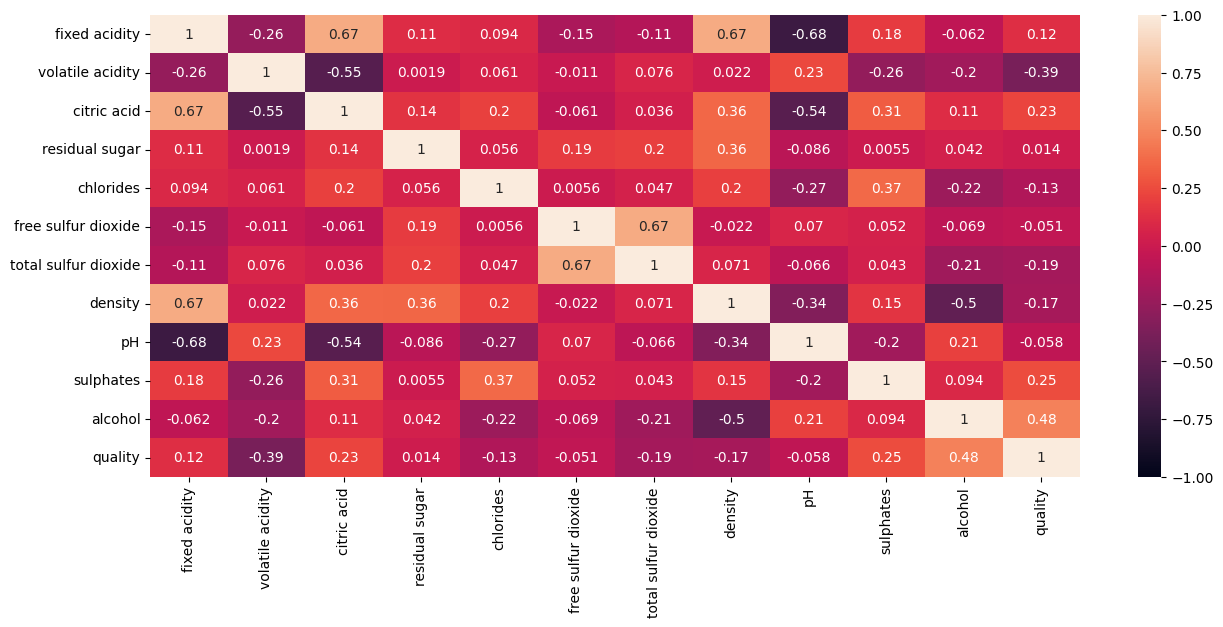

In [6]:
# Correlation Matrix
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

In [7]:
from ydata_profiling import ProfileReport
profile = ProfileReport(
    df, 
    title="Profiling Report", 
    explorative=True,
)
profile.to_file("wine_quality_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Removing the target column quality to get clusters from the variables
new_df = df.drop(columns=['quality'])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
dtypes: float64(11)
memory usage: 137.5 KB


In [9]:
new_df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5


In [10]:
# ML
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Otimização HP
import optuna

In [11]:
# Preparing data to better range of values
X = new_df.copy()

In [12]:
# Optuna for Hyperparameters optimization 
def kmeans_objective(trial):
    
    # Defining the hyperparameters to be adjusted
    n_clusters = trial.suggest_int('n_clusters', 3, 6)
    distance_metric = trial.suggest_categorical('distance_metric', ['euclidean', 'minkowski'])

    # Creating the model
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=51)

    # Training the model
    kmeans_model.fit(X)

    # Calculating the Silhouette Score
    distances = pairwise_distances(X, metric=distance_metric)
    silhouette_avg = silhouette_score(distances, kmeans_model.labels_)

    return silhouette_avg

In [13]:
# Creating a Optuna study
search_space = {'n_clusters': [3, 4, 5, 6], 'distance_metric': ['euclidean', 'minkowski']}
sampler = optuna.samplers.GridSampler(search_space=search_space)
kmeans_study = optuna.create_study(direction='maximize', sampler=sampler)

# Start the study
kmeans_study.optimize(kmeans_objective, n_trials=100)

[I 2025-01-09 20:15:43,049] A new study created in memory with name: no-name-d76e83a9-0da6-4837-9c8c-a1e2a3efe8cf
[I 2025-01-09 20:15:43,498] Trial 0 finished with value: 0.5122354600699274 and parameters: {'n_clusters': 5, 'distance_metric': 'minkowski'}. Best is trial 0 with value: 0.5122354600699274.
[I 2025-01-09 20:15:43,784] Trial 1 finished with value: 0.5122354600718685 and parameters: {'n_clusters': 5, 'distance_metric': 'euclidean'}. Best is trial 1 with value: 0.5122354600718685.
[I 2025-01-09 20:15:43,938] Trial 2 finished with value: 0.5337461408949475 and parameters: {'n_clusters': 4, 'distance_metric': 'euclidean'}. Best is trial 2 with value: 0.5337461408949475.
[I 2025-01-09 20:15:44,055] Trial 3 finished with value: 0.4889815907093231 and parameters: {'n_clusters': 6, 'distance_metric': 'minkowski'}. Best is trial 2 with value: 0.5337461408949475.
[I 2025-01-09 20:15:44,165] Trial 4 finished with value: 0.48898159071119757 and parameters: {'n_clusters': 6, 'distance_m

In [14]:
# Best configuration found by Optuna
best_params = kmeans_study.best_params

# Instanciating K-Means models with the best params
best_kmeans = KMeans(n_clusters=best_params['n_clusters'], random_state=51)
best_kmeans.fit(X)

# Calculating the Silhouette Score
distances = pairwise_distances(X, metric=best_params['distance_metric'])
best_silhouette = silhouette_score(distances, best_kmeans.labels_)

print(f'k (Numero de Clusters): {best_params['n_clusters']}')
print(f'Métrica de Distancia Selecionada: {best_params['distance_metric']}')
print(f'Silhouette Score: {best_silhouette}')

k (Numero de Clusters): 3
Métrica de Distancia Selecionada: euclidean
Silhouette Score: 0.5432316480085377


In [15]:
# Creating Column with the best cluster chosen
new_df['cluster'] = best_kmeans.labels_

In [16]:
new_df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,cluster
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,2
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,2
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,0
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,0
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,1


In [17]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  cluster               1599 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 143.8 KB


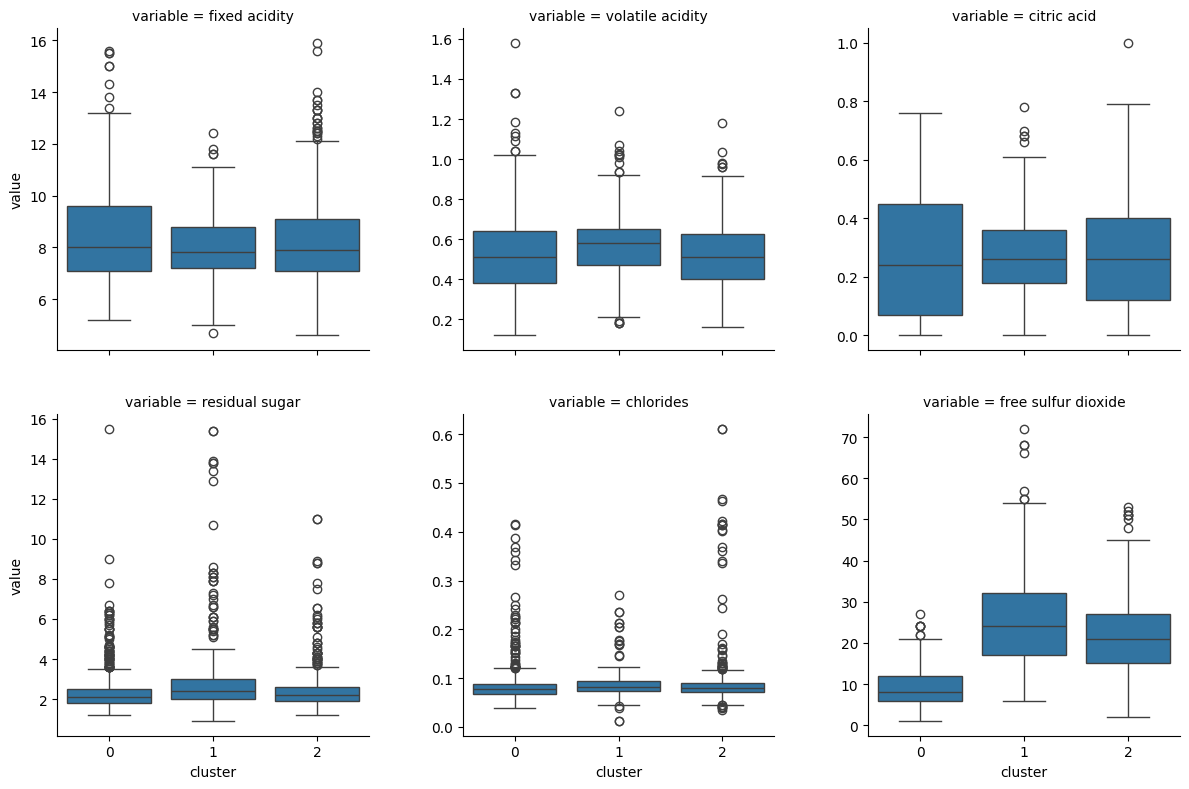

In [18]:
# List of variables to plot
variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide']

# Define the order of 'cluster'
order = sorted(new_df['cluster'].unique())

# Use FacetGrid
grid = sns.FacetGrid(data=new_df.melt(id_vars='cluster', value_vars=variables), 
                  col='variable', col_wrap=3, sharey=False, height=4)
grid.map(sns.boxplot, 'cluster', 'value', order=order)
grid.figure.subplots_adjust(hspace=0.2, wspace=0.3)

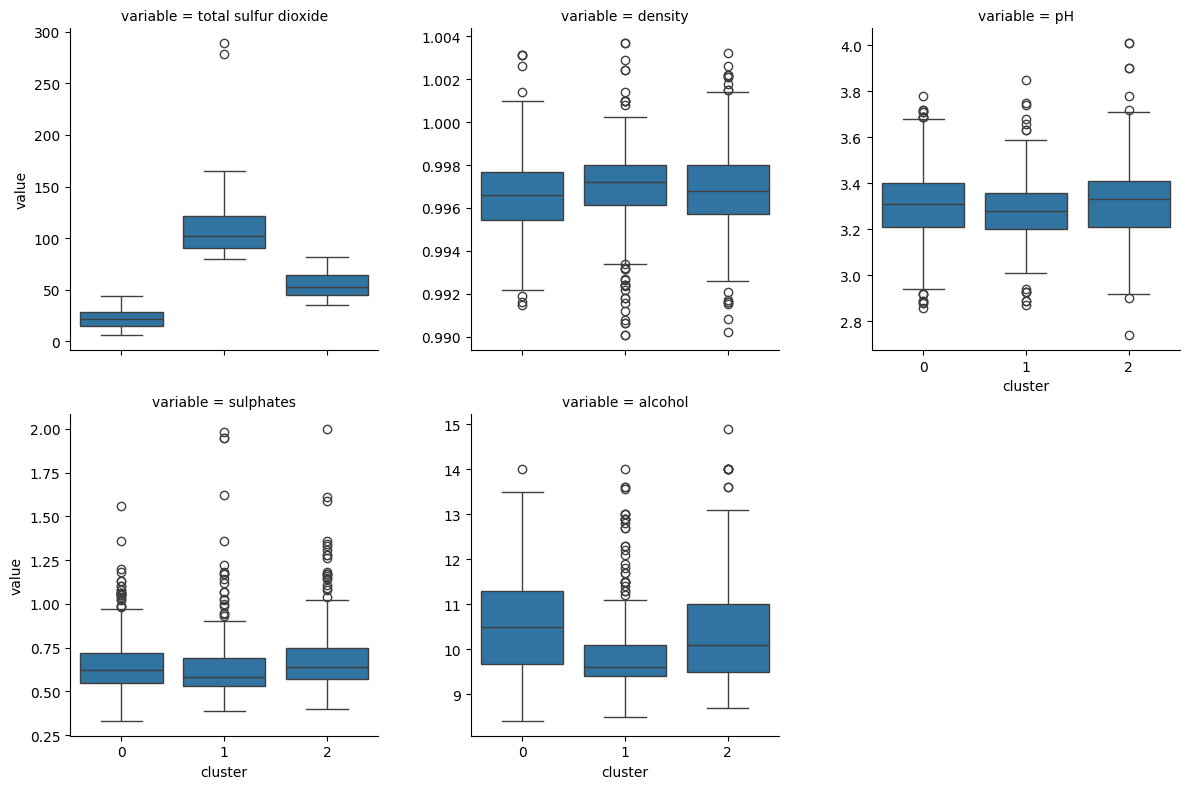

In [19]:
# List of variables to plot
variables = ['total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# Define the order of 'cluster'
order = sorted(new_df['cluster'].unique())

# Use FacetGrid
grid = sns.FacetGrid(data=new_df.melt(id_vars='cluster', value_vars=variables), 
                  col='variable', col_wrap=3, sharey=False, height=4)
grid.map(sns.boxplot, 'cluster', 'value', order=order)
grid.figure.subplots_adjust(hspace=0.2, wspace=0.3)

In [20]:
import plotly.express as px

In [21]:
px.scatter(new_df, x='total sulfur dioxide', y='free sulfur dioxide', color='cluster')

In [22]:
log_total_sulfur_dioxide = np.log(new_df['total sulfur dioxide'])
log_free_sulfur_dioxide = np.log(new_df['free sulfur dioxide'])

<Axes: xlabel='free sulfur dioxide', ylabel='total sulfur dioxide'>

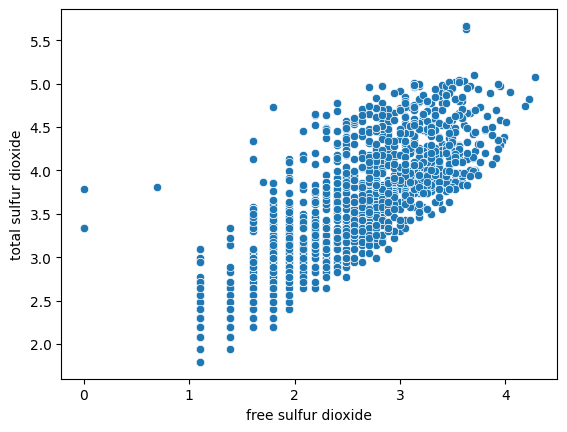

In [23]:
sns.scatterplot(x=log_free_sulfur_dioxide, y=log_total_sulfur_dioxide)